### Learning Python with Data Seattle's Work Habits


In [1]:
import pandas as pd
data = pd.read_csv('/root/data/FremontBridge.csv', index_col='Date', parse_dates=True)
data.head()

,Fremont Bridge West Sidewalk,Fremont Bridge East Sidewalk
Date,,
2012-10-03 00:00:00,4.0,9.0
2012-10-03 01:00:00,4.0,6.0
2012-10-03 02:00:00,1.0,1.0
2012-10-03 03:00:00,2.0,3.0
2012-10-03 04:00:00,6.0,1.0


In [2]:
data.columns = ['West', 'East']
data.fillna(0, inplace=True)
data['Total'] = data.eval('East + West')

/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  import sys


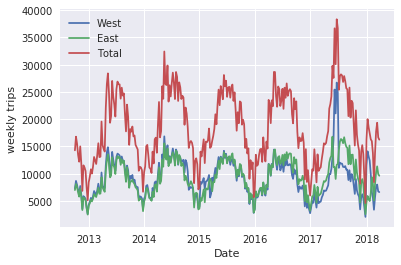

In [3]:
# first some standard imports
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # plot styling
import numpy as np

data.resample('W', how='sum').plot()
plt.ylabel('weekly trips');

In [4]:
pivoted = data.pivot_table(['East', 'West'],
                           index=data.index.date,
                           columns=data.index.hour,
                           fill_value=0)
pivoted.head()

East                                    ... West                 \
Date         0  1  2  3  4   5   6    7    8    9  ...   14   15   16   17   
2012-10-03    9  6  1  3  1  10  50   95  146  104 ...   77   72  133  192   
2012-10-04   11  0  6  3  1  11  51   89  134   94 ...   63   73  114  154   
2012-10-05    7  4  3  2  2   7  37  101  119   81 ...   63   80  120  144   
2012-10-06    7  5  2  2  1   2  15   16   47   55 ...   89  115  107  107   
2012-10-07    5  5  1  2  2   3   8   12   26   36 ...  126  122  132  118   

                                     
Date         18  19  20  21  22  23  
2012-10-03  122  59  29  25  24   5  
2012-10-04  137  57  27  31  25  11  
2012-10-05  107  42  27  11  10  16  
2012-10-06   41  40  25  18  14  15  
2012-10-07   68  26  19  12   9   5  

[5 rows x 48 columns]

In [5]:
X = pivoted.values
X.shape

(2006, 48)

In [6]:
from sklearn.decomposition import PCA
Xpca = PCA(0.9).fit_transform(X)
Xpca.shape

(2006, 3)

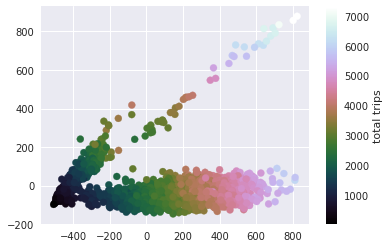

In [7]:
total_trips = X.sum(1)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c=total_trips,
            cmap='cubehelix')
plt.colorbar(label='total trips');

/root/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/root/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/root/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/root/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning:

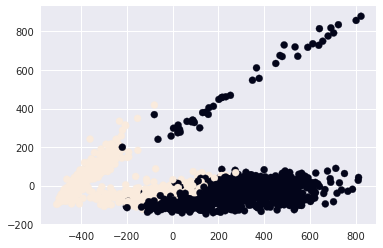

In [8]:
from sklearn.mixture import GMM
gmm = GMM(2, covariance_type='full', random_state=0)
gmm.fit(Xpca)
cluster_label = gmm.predict(Xpca)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c=cluster_label);

In [9]:
pivoted['Cluster'] = cluster_label
data = data.join(pivoted['Cluster'], on=data.index.date)
data.head()

,West,East,Total,Cluster
Date,,,,
2012-10-03 00:00:00,4.0,9.0,13.0,0
2012-10-03 01:00:00,4.0,6.0,10.0,0
2012-10-03 02:00:00,1.0,1.0,2.0,0
2012-10-03 03:00:00,2.0,3.0,5.0,0
2012-10-03 04:00:00,6.0,1.0,7.0,0


In [10]:
by_hour = data.groupby(['Cluster', data.index.time]).mean()
by_hour.head()

West      East      Total
Cluster                                        
0       00:00:00  5.118938  6.357968  11.476905
        01:00:00  2.550808  2.856813   5.407621
        02:00:00  1.877598  1.837182   3.714781
        03:00:00  1.709007  1.393764   3.102771
        04:00:00  4.953811  3.538106   8.491917

/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


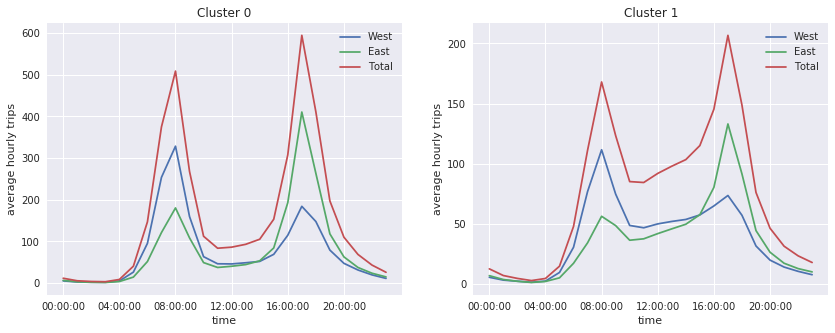

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
hourly_ticks = 4 * 60 * 60 * np.arange(6)

for i in range(2):
    by_hour.ix[i].plot(ax=ax[i], xticks=hourly_ticks)
    ax[i].set_title('Cluster {0}'.format(i))
    ax[i].set_ylabel('average hourly trips')

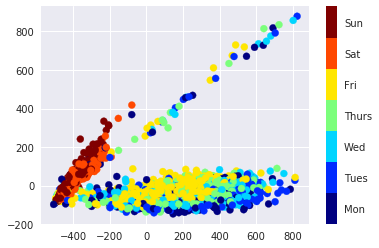

In [12]:
dayofweek = pd.to_datetime(pivoted.index).dayofweek
plt.scatter(Xpca[:, 0], Xpca[:, 1], c=dayofweek,
            cmap=plt.cm.get_cmap('jet', 7))
cb = plt.colorbar(ticks=range(7))
cb.set_ticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.clim(-0.5, 6.5);

In [13]:
results = pd.DataFrame({'cluster': cluster_label,
                        'is_weekend': (dayofweek > 4),
                        'weekday': pivoted.index.map(lambda x: x.strftime('%a'))},
                       index=pivoted.index)
results.head()

,cluster,is_weekend,weekday
2012-10-03,0,False,Wed
2012-10-04,0,False,Thu
2012-10-05,1,False,Fri
2012-10-06,1,True,Sat
2012-10-07,1,True,Sun


In [14]:
weekend_workdays = results.query('cluster == 0 and is_weekend')
len(weekend_workdays)

1

In [15]:
midweek_holidays = results.query('cluster == 1 and not is_weekend')
len(midweek_holidays)

568

In [16]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016', return_name=True)
holidays.head()

2012-01-02                 New Years Day
2012-01-16    Dr. Martin Luther King Jr.
2012-02-20                Presidents Day
2012-05-28                   MemorialDay
2012-07-04                      July 4th
dtype: object

In [17]:
holidays_all = pd.concat([holidays,
                         "Day Before " + holidays.shift(-1, 'D'),
                         "Day After " + holidays.shift(1, 'D')])
holidays_all = holidays_all.sort_index()
holidays_all.head()

2012-01-01                 Day Before New Years Day
2012-01-02                            New Years Day
2012-01-03                  Day After New Years Day
2012-01-15    Day Before Dr. Martin Luther King Jr.
2012-01-16               Dr. Martin Luther King Jr.
dtype: object

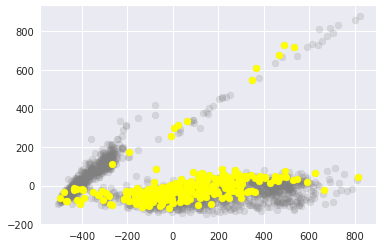

In [18]:
fridays = (dayofweek == 4)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c='gray', alpha=0.2)
plt.scatter(Xpca[fridays, 0], Xpca[fridays, 1], c='yellow');

In [19]:
holidays_all.name = 'name'  # required for join
joined = midweek_holidays.join(holidays_all)
set(joined['name'])

{'Christmas',
 'Day After Christmas',
 'Day After Dr. Martin Luther King Jr.',
 'Day After July 4th',
 'Day After Labor Day',
 'Day After New Years Day',
 'Day After Presidents Day',
 'Day After Thanksgiving',
 'Day After Veterans Day',
 'Day Before Christmas',
 'Day Before July 4th',
 'Day Before New Years Day',
 'Day Before Thanksgiving',
 'Dr. Martin Luther King Jr.',
 'July 4th',
 'Labor Day',
 'MemorialDay',
 'New Years Day',
 'Presidents Day',
 'Thanksgiving',
 'Veterans Day',
 nan}

In [20]:
set(holidays) - set(joined.name)

{'Columbus Day'}

In [21]:
results = pd.DataFrame({'cluster': cluster_label,
                        'is_weekend': (dayofweek > 4),
                        'weekday': pivoted.index.map(lambda x: x.strftime('%a'))},
                       index=pivoted.index)
results.head()

,cluster,is_weekend,weekday
2012-10-03,0,False,Wed
2012-10-04,0,False,Thu
2012-10-05,1,False,Fri
2012-10-06,1,True,Sat
2012-10-07,1,True,Sun


In [22]:
weird_fridays = pivoted.index[fridays & (Xpca[:, 0] < -600)]
weird_fridays

Index([], dtype='object')

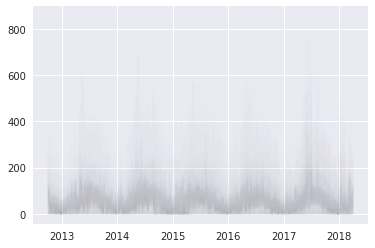

In [23]:
pivoted.plot(legend=False, alpha= 0.01);